# Overview

In this notebook we tried to find a sufficent enough solution for the **TSP** problem using genetic or memtic algorithems. 
Here we describe shortly the following concepts in a genetic algorithems that we used in this notebook

### 1. Gene
We used a permutation as gene in this problem due to the fact that each hamiltonian path (or cycle) should contain each vertex in the graph exactly once, mimicing a permutation. 

### 2. Initial population
Instead of using all random shuffled permutations we used a greedy approach as we call it `NeaigherstNeighbor`, in this approach, an starting vertex is randomly selected, and from then, we start greedily pick the next vertex in the path that is closest to the current vertex and not yet been selected in the path. In order to bring diversity, we used 50% of the greedy algorithem and 50% of a random shuffled permutation.

### 3. Fitness finction
The obvious fitness function for this problem is the some of weights of edges in the path. 

$ fitness(gene) = \sum_{edge \in path}^{} W(edge) $

### 4. Mutation
Out mutation is as a matter of facts a simple process in graph called ***switch***. Figure we have two edges a &rarr; b and c &rarr; d, we switch the edges to be like a &rarr; d and b &rarr; c, this does not make any abrupt changes in the fitness function that the mutated version is not going to be a candidate for a good solution anymore, but also it changes so slightly that it may be able to escape simple local minumum implemented as `mutation`.

### 5. crossover
I tried various simple crossovers, implemented as `crossover` , `crossover2` and `cycle_crossover` which are ***two-cut crossover***, ***one-cut crossover*** and ***cycle decomposition crossover*** which are common functions for a permutation gene. however they did not bring good enough results. my own function named as `my_crossover` is a bit different. The idea originates from the fact that there are some small subsegments of each path, that are almost in every good solution, but the way these subsegments are put toghether, makes the differences. so I find these mutual subsegments in both parents and reconnect them greedily to each other.

### 6. Other
The other parts that are of less importance are shown using comments in the code like the selection method or recombination.

# Setup

In [189]:
import random
import numpy as np
import pandas as pd

# Import Data

In [148]:
def testcase(id) : 
    tstcase = pd.read_csv("TSP-Tests/" + id + ".tsp")
    n = int(tstcase.iloc[2, 0].split()[1])
    pos = []
    for i in range(n) :
        x, y = map(float, tstcase.iloc[6 + i, 0].split()[1:])
        pos.append([x, y])

    return n, pos

In [5]:
import math

In [6]:
def dist(p1, p2) : 
    return math.sqrt((p1[0] - p2[0])**2 + (p1[1] - p2[1])**2)

In [192]:
n, pos = testcase("gr229")
W = []
global W
for i in range(n) :
    W.append([])
    for j in range(n) :
        W[i].append(dist(pos[i], pos[j]))

# Gene

In [197]:
class Gene() : 

    def __init__(self, n) : 
        self.n = n

        self.path = list(range(self.n))
        random.shuffle(self.path)

        self.fitness = self.cal_fitness()

    def cal_fitness(self) : 
        fit = 0
        for i in range(self.n) : 
            fit += W[self.path[(i) % self.n]][self.path[(i + 1) % self.n]]
        
        self.fitness = fit
        return self.fitness


    def mutation(self, alpha = 0.15) : 
        if random.random() < alpha:
            edge_a = random.randint(0, self.n - 2)
            edge_b = random.randint(0, self.n - 2)
            if(edge_a > edge_b) : 
                edge_a, edge_b = edge_b, edge_a
            self.path = self.path[:edge_a + 1] + self.path[edge_b + 1:] + self.path[edge_a + 1: edge_b + 1]
        
        self.cal_fitness()

    def local_search(self, iter = 20) : 
        for _ in range(iter) : 
            temp = Gene(self.n)
            temp.path = self.path.copy()

            for i in range(self.n // 20) : 
                a = random.randint(0, self.n - 1)
                b = random.randint(0, self.n - 1)
                self.path[a], self.path[b] = self.path[b], self.path[a]
        
            temp.cal_fitness()
            if(temp.fitness > self.fitness) : 
                self.path = temp.path
                self.fitness = temp.fitness

# Crossover

In [9]:
def crossover(par1 : Gene, par2 : Gene) -> Gene : 
    child = Gene(par1.n)

    start = random.randint(0, par1.n - 2)  
    end = random.randint(start, par1.n - 1)  

    center = par2.path[start : end + 1]
    left = []
    right = []

    counter = 0

    for i in range(len(par1.path)):
        if (par1.path[i] not in center):
            if (counter < start):
                left.append(par1.path[i])
            else:
                right.append(par1.path[i])
            counter += 1
            
    child.path = left + center + right
    child.cal_fitness()
    
    return child

In [10]:
def crossover2(par1 : Gene, par2 : Gene) -> Gene : 
    child = Gene(par1.n)

    start = 0
    end = random.randint(0, par1.n - 1)  

    center = par2.path[start : end + 1]
    left = []
    right = []

    counter = 0

    for i in range(len(par1.path)):
        if (par1.path[i] not in center):
            if (counter < start):
                left.append(par1.path[i])
            else:
                right.append(par1.path[i])
            counter += 1
            
    child.path = left + center + right
    child.cal_fitness()
    
    return child

In [11]:
def cycle_crossover(par1 : Gene, par2 : Gene) -> Gene : 
    child = Gene(par1.n)

    cycles = []
    mark = []
    for i in range(par1.n) : 
        if(par1.path[i] in mark) : 
            continue
            
        
        cycle = []
        node = par1.path[i]
        while(node not in cycle) : 
            cycle.append(node) 
            mark.append(node)
            node = par1.path[par2.path.index(node)]
        
        cycles.append(cycle)
    
    for i in range(par1.n) : 
        x = par1.path[i]
        idx = 0
        for j in range(len(cycles)) : 
            if(x in cycles[j]) : 
                idx = j
                break
        
        if(idx % 2 == 0) :
            child.path[i] = par1.path[i]
        else : 
            child.path[i] = par2.path[i]

    child.cal_fitness()
    
    return child

In [182]:
def my_crossover(par1 : Gene, par2 : Gene) -> Gene :
    child = Gene(par1.n)
    child.path = par1.path.copy()

    segments = []
    seg = [child.path[0]]
    for i in range(1, par1.n) :
        if(abs(par2.path.index(child.path[i]) - par2.path.index(child.path[i - 1])) == 1) : 
            seg.append(child.path[i])
        else :
            segments.append(seg)
            seg = [child.path[i]]
    
    segments.append(seg)

    mark = [0] * len(segments)
    mark[0] = 1
    par = [i for i in range(len(segments))]

    pth = segments[0]
    i = 0
    for _ in range(len(segments) - 1) : 
        bst_seg = 0
        bst_val = 1000000
        for j in range(len(segments)) : 
            en = segments[i][-1]
            st = segments[j][0]
            if(mark[j] == 0 and W[en][st] < bst_val) : 
                bst_val = W[en][st]
                bst_seg = j
        
        mark[bst_seg] = 1
        par[bst_seg] = par[i]  
        i = bst_seg
        pth.extend(segments[bst_seg])

    child.path = pth
    child.cal_fitness()
    if(len(set(child.path)) != par1.n) : 
        print(segments)
        print(mark)
        print(par)
        print(child.path)

    return child

In [125]:
def NearstNeighborGreedy(st, n) : 
    res = Gene(n)
    res.path = [st]

    mark = [0] * n
    mark[st] = 1

    while(len(res.path) != n) : 
        v = res.path[-1]
        bst_value = 1000000
        bst_node = 0
        for i in range(n) : 
            if(W[v][i] < bst_value and mark[i] == 0) :
                bst_node = i
                bst_value = W[v][i]
        res.path.append(bst_node)
        mark[bst_node] = 1

    return res

# Genetic Algorithem

In [204]:
def genetic_algorithem(iterations, pop_size, n, alpha = 0.2, is_memtic = False, elite_rate = 0.05, prep_p = 0.2) :
    hist = []
    # first population
    # --------------------------------
    population = []
    for i in range(pop_size // 2) : 
        st = random.randint(0, n - 1)
        population.append(NearstNeighborGreedy(st, n))

    for i in range(pop_size // 2) :
        population.append(Gene(n))
        
    # random.shuffle(population)
    population.sort(key = lambda x : x.fitness, reverse = False)
    # --------------------------------

    hist.append(population[0].fitness)
    for _ in range(iterations) :
        elite = population[:int(n * elite_rate)]
        children = []

        # selection
        # --------------------------------
        for __ in range(pop_size) :
            # parents = random.choices(population, k = 2, weights = [(n - i)/(n*(n + 1)/2) for i in range(len(population))])

            # tournament
            parents = random.choices(population, k = 3, weights = [1 for i in range(len(population))])
            parents.sort(key = lambda x : x.fitness, reverse = False)
            parents = parents[:2]
            
            # crossover
            # --------------------------------
            child = my_crossover(*parents)
            # --------------------------------

            # mutation
            # --------------------------------
            child.mutation(alpha)
            # --------------------------------

            children.append(child)    
        # --------------------------------

        # local search (Memtic Algorithem)
        # --------------------------------
        if is_memtic : 
            for i in range(len(children) // 2) : 
                children[i].local_search()
        # --------------------------------

        # replacement
        # --------------------------------
        npop = elite
        children.sort(key = lambda x : x.fitness, reverse = False)
        
        for gene in population[len(elite):] : 
            q = random.random()
            if(q < prep_p) : 
                npop.append(gene)

        rem = pop_size - len(npop)
        for i in range(int(rem * 0.05)) : 
            npop.append(children[i])
        
        while(len(npop) != pop_size) : 
            x = random.randint(int(rem * 0.05), len(children) - 1)
            npop.append(children[x])

        population = npop
        population.sort(key = lambda x : x.fitness, reverse = False)

        # --------------------------------

        if(_ % 50 == 0) : 
            print('best_fitness of iter ' ,_, " : ",  population[0].fitness)

        # exit strategy
        # --------------------------------

        # --------------------------------

        hist.append(population[0].fitness)
    
    return [population[0], hist]

# Plot solution

In [13]:
from matplotlib import pyplot as plt

In [14]:
def draw_solution(sol, cities) : 
    for i in range(len(cities)) : 
        plt.plot(cities[i][0], cities[i][1], "o")
        plt.annotate(i, (cities[i][0], cities[i][1]))

    for i in range(len(sol.path)) :
        u = cities[sol.path[(i) % sol.n]]
        v = cities[sol.path[(i + 1) % sol.n]]

        plt.plot([u[0], v[0]], [u[1], v[1]], "gray")
    
    plt.show()

In [200]:
def draw_plot(hist) : 
    plt.plot(hist)
    plt.xlabel("number of iterations")
    plt.ylabel("fitness function")
    plt.show()

# Testcase #1

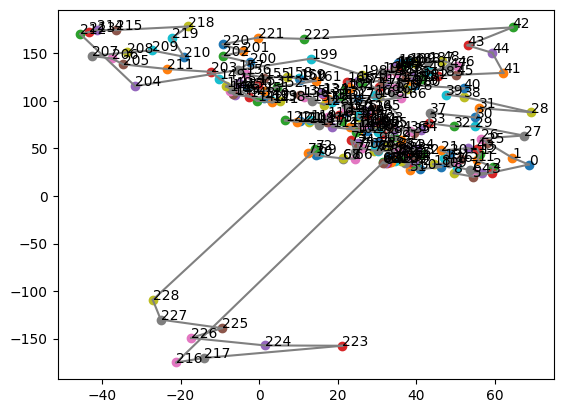

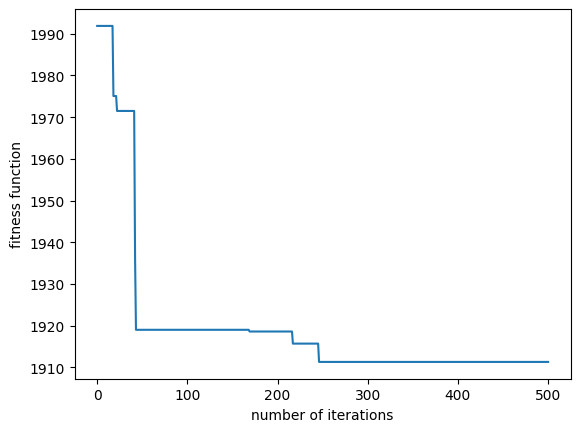

In [212]:
res = genetic_algorithem(501, 100, n)
sol = res[0]
hist = res[1]
draw_solution(sol, pos)
draw_plot(hist[1:])

# Testcase #2

In [213]:
n, pos = testcase("pr1002")
W = []
global W
for i in range(n) :
    W.append([])
    for j in range(n) :
        W[i].append(dist(pos[i], pos[j]))

best_fitness of iter  0  :  316653.2034460359
best_fitness of iter  50  :  312185.29473546124
best_fitness of iter  100  :  311963.9835895973
best_fitness of iter  150  :  311963.9835895973
best_fitness of iter  200  :  311963.9835895973
best_fitness of iter  250  :  311963.9835895973
best_fitness of iter  300  :  311963.9835895973


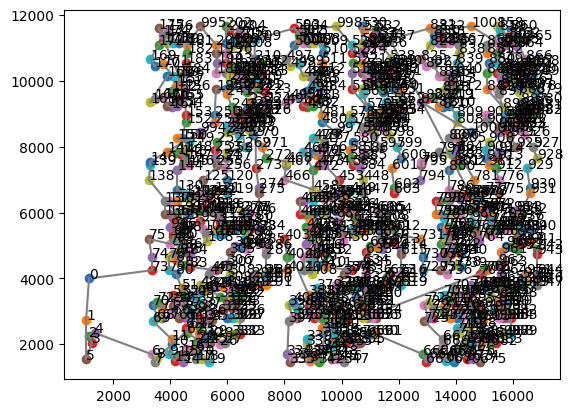

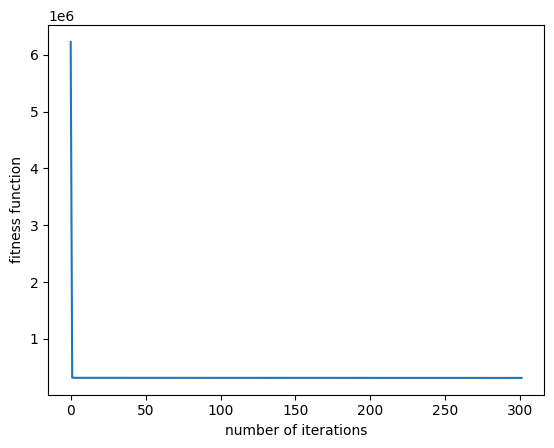

In [216]:
res2 = genetic_algorithem(301, 100, n)
sol2 = res2[0]
hist2 = res2[1]
draw_solution(sol2, pos)
draw_plot(hist2)